# Проверка статистических гипотез

In [114]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import scipy.stats

from statsmodels.stats.weightstats import *
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.proportion import proportion_confint, samplesize_confint_proportion

from sklearn import model_selection, datasets, linear_model, metrics

%matplotlib inline

# Доверительные интервалы

## Генерация данных

In [138]:
np.random.seed(1)

statistical_population = np.random.randint(2, size = 1000) 

random_sample = np.random.choice(statistical_population, size = 1000)

In [129]:
#истинное значение доли
statistical_population.mean()

0.49770999999999999

## Точечная оценка доли

In [130]:
random_sample.mean() - statistical_population.mean()

0.004290000000000016

## Доверительный интервал для доли

### Доверительный интервал на основе нормального распределения

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [139]:
# используйте функцию proportion_confint чтобы посчитать этот интервал
l, r = proportion_confint(np.sum(statistical_population), statistical_population.shape[0])

In [137]:
r - l

0.0061978853173620951

In [140]:
r - l

0.061919478005045103

In [82]:
# выведите его границы

### Доверительный интервал Уилсона

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [135]:
# считаем интервал
proportion_confint(np.sum(statistical_population), statistical_population.shape[0], method='wilson')

(0.49461120482668647, 0.50080897110536926)

In [84]:
# выводим его границы и ширину

## Размер выборки для интервала заданной ширины

In [86]:
#используйте samplesize_confint_proportion чтобы оценить размер выборки, 
#дающей доверительный интервал на долю определённого размера

In [144]:
samplesize_confint_proportion(0.7, 0.003)

89634.039149529621

--------------

--------------

--------------

# Доверительные интервалы для двух долей 

## Загрузка данных

In [88]:
data = pd.read_csv('banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

In [145]:
data.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [147]:
print("Banner a")

print(proportion_confint(np.sum(data.banner_a), data.shape[0]))

Banner a
(0.02530064022092865, 0.048699359779071347)


In [148]:
print("Banner b")

print(proportion_confint(np.sum(data.banner_b), data.shape[0]))

Banner b
(0.039114516224867821, 0.066885483775132176)


## Интервальные оценки долей

In [90]:
# выведите интервальные оценки долей для первого и второго баннера

### Как их сравнить?

## Доверительный интервал для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [156]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    # считаем оценки для колонок и интервал
    p1 = sample1.sum() / sample1.shape[0]
    p2 = sample2.sum() / sample2.shape[0]
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / sample1.shape[0] + p2 * (1 - p2) / sample2.shape[0])
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / sample1.shape[0] + p2 * (1 - p2) / sample2.shape[0])
    return (left_boundary, right_boundary)

In [157]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(data.banner_a, data.banner_b))

confidence interval: [-0.034157, 0.002157]


In [160]:
a, b = proportions_confint_diff_ind(data.banner_a, data.banner_b)

In [161]:
b - a

0.036314277022108599

## Доверительный интервал для разности долей (связанные выборки)

  $X_1$ \ $X_2$ | 1| 0 | $\sum$
  ------------- | -------------|
  1  | e | f | e + f
  0  | g | h | g + h
  $\sum$ | e + g| f + h | n  
  
$$ \hat{p}_1 = \frac{e + f}{n}$$

$$ \hat{p}_2 = \frac{e + g}{n}$$

$$ \hat{p}_1 - \hat{p}_2 = \frac{f - g}{n}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\;  \frac{f - g}{n} \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{f + g}{n^2} - \frac{(f - g)^2}{n^3}}$$

In [158]:
def proportions_confint_diff_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    # считаем оценки для колонок и интервал
    f = np.sum((sample1==1) * (sample2==0))
    g = np.sum((sample1==0) * (sample2==1))
    n = sample1.shape[0]
    
    left_boundary = (f - g) / n - z * np.sqrt((f + g) / (n ** 2) - (f-g)**2/(n**3))
    right_boundary = (f - g) / n + z * np.sqrt((f + g) / (n ** 2) - (f-g)**2/(n**3))
    return (left_boundary, right_boundary)


In [162]:
a, b = proportions_confint_diff_rel(data.banner_a, data.banner_b)
b - a

/Users/binom/.anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


0.02137852671843652

In [159]:
print("confidence interval: [%f, %f]" % 
      proportions_confint_diff_rel(data.banner_a, data.banner_b))

confidence interval: [-0.026689, -0.005311]


/Users/binom/.anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Доверительные интервалы для оценки среднего

## Генерация данных

In [164]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

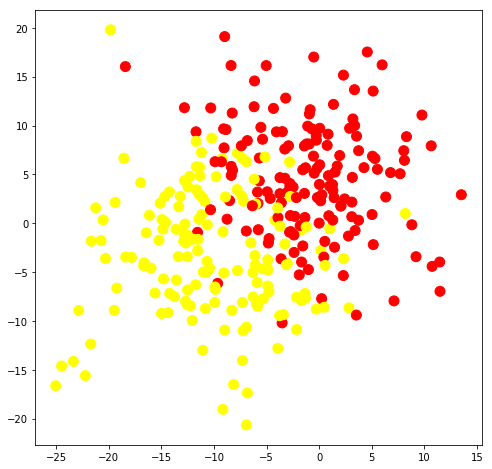

In [165]:
plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in blobs[0]], 
              [x[1] for x  in blobs[0]], c = blobs[1], cmap = 'autumn',
             s=100);

## Сравнение линейных моделей

### Точечная оценка

In [166]:
train_data, test_data, train_labels, test_labels = \
    model_selection.train_test_split(blobs[0], blobs[1], test_size = 15,
                                     random_state = 1)

In [102]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.88888888888888884

In [168]:
sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

/Users/binom/.anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.88888888888888884

### Оценка среднего

In [174]:
# используйте model_selection.cross_val_score чтобы оценить модель на разных фолдах
?model_selection.cross_val_score

In [183]:
sgd_auc_scores = model_selection.cross_val_score(linear_model.SGDClassifier(random_state = 0), blobs[0], blobs[1], cv=40)
ridge_auc_scores = model_selection.cross_val_score(linear_model.RidgeClassifier(random_state = 0), blobs[0], blobs[1], cv=40)

/Users/binom/.anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/binom/.anaconda3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/binom/.

### Точечная оценка среднего

In [184]:
print("sgd model auc: mean %.3f, std %.3f" % 
      (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print("ridge model auc: mean %.3f, std %.3f" % 
      (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.798, std 0.161
ridge model auc: mean 0.860, std 0.142


### Интервальная оценка среднего 

In [185]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [186]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [187]:
from math import sqrt

print("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(sgd_auc_scores)), 
                                                                    0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.64296790859052622, 0.952865424742807)
ridge model mean auc 95%% confidence interval (0.70546790859052622, 1.015365424742807)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [188]:
type(sgd_auc_scores)

numpy.ndarray

In [189]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))

In [190]:
print("sgd model mean auc 95%% confidence interval", 
      _tconfint_generic(sgd_mean, sgd_mean_std,
                        len(sgd_auc_scores) - 1, 0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", 
      _tconfint_generic(ridge_mean, ridge_mean_std,
                        len(sgd_auc_scores) - 1, 0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.74656757510765726, 0.84926575822567596)
ridge model mean auc 95%% confidence interval (0.81509640634824498, 0.90573692698508823)


# Параметрические методы

## Критерий согласия Пирсона ( $\chi^2$)

## Исчерпанная рождаемость

Исчерпанная рождаемость — количество детей, родившихся у женщины на момент окончания конвенционального репродуктивного возраста (45 лет). Для 1878 женщин старше 45, участвовавших в социологическом опросе жителей Швейцарии, известно количество детей. Этот признак — типичный счётчик, а, значит, его можно попробовать описать распределением Пуассона.

* **выборка** - целочисленный вектор длиы $n$, характеризующий количество детей у опрашиваемой женщины
* **гипотеза $H_0$** - рассматриваемая величина имеет распределение Пуассона

In [191]:
fin = open('fertility.txt', 'r')
data = np.array([int(x.strip()) for x in fin.readlines()])

In [192]:
data[:20]

array([0, 0, 2, 0, 2, 3, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 3, 2, 2, 4])

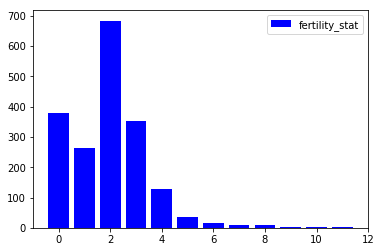

In [193]:
plt.bar(range(12), np.bincount(data), color = 'b', label = 'fertility_stat')
plt.legend();

Очень похоже на распределение Пуассона с параметром $\lambda$:

In [194]:
lamb = data.mean()
lamb

1.9371671991480299

Похожесть двух распределений можно проверить с помощью критерия согласия Пирсона:

$H_0\colon$ распределение данных совпадает с F(x)
    
$H_1\colon$ данные распределены по другому закону, нежели F(x)
    
   
Чтобы проверить статистику, мы разбиваем область значений переменной на интервалы $[a_i; b_i ]$ и считаем $n_i$ -  количество наблюдений, попавших в i-тый интервал.
   
Пусть $e_i = n * (F(b_i) - F(a_i))$ - ожидаемое количество наблюдений в интервале, если бы данные были распределены по закону $F(x)$
   
В качестве статистики мы используем такую вещь: $\chi^2 = \sum_{i}\frac{(n_i - e_i) ^ 2}{e_i}$

Такая статистика будет иметь распределение $\chi^2$ с $(k-1)$ степенью свободы.

In [195]:
np.bincount(data)

array([379, 262, 684, 353, 128,  35,  16,   8,  10,   1,   1,   1])

$F(1) - F(0)$

In [202]:
data.shape[0] * (scipy.stats.poisson.cdf(1, lamb) - scipy.stats.poisson.cdf(0, lamb))

524.27804296009845

In [207]:
# посчитаем с помощью np.bincount интервалы и количество попаданий в них
observed_frequences = np.bincount(data)

# ожидаемое количество попаданий в интервалы; полезной функцией будет scipy.stats.poisson
expected_frequences = []
for i in range(12):
    expected_frequences.append(data.shape[0] * (scipy.stats.poisson.cdf(i + 1, lamb) - scipy.stats.poisson.cdf(i, lamb)))

In [208]:
len(observed_frequences)

12

In [209]:
len(expected_frequences)

12

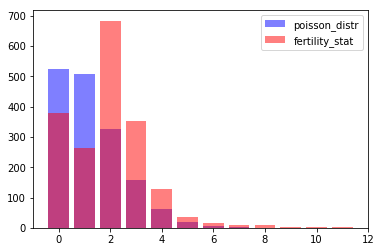

In [210]:
plt.bar(range(len(expected_frequences)), 
          expected_frequences, color = 'blue',  alpha=0.5, label = 'poisson_distr')
plt.bar(range(len(observed_frequences)), observed_frequences, color = 'red', alpha=0.5, label = 'fertility_stat')
plt.legend();

P-value

In [211]:
scipy.stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=1997.7761783470628, pvalue=0.0)

## Treatment effects of methylphenidate

В рамках исследования эффективности препарата метилфенидат 24 пациента с синдромом дефицита внимания и гиперактивности в течение недели принимали либо метилфенидат, либо плацебо. В конце недели каждый пациент проходили тест на способность к подавлению импульсивных поведенческих реакций. На втором этапе плацебо и препарат менялись, и после недельного курса каждый испытуемые проходили второй тест.

Требуется оценить эффект применения препарата.

In [27]:
data = pd.read_csv('ADHD.txt', sep = ' ', header = 0)
data.columns = ['Placebo', 'Methylphenidate']

In [28]:
data.head()

,Placebo,Methylphenidate
0,57,62
1,27,49
2,32,30
3,31,34
4,34,38


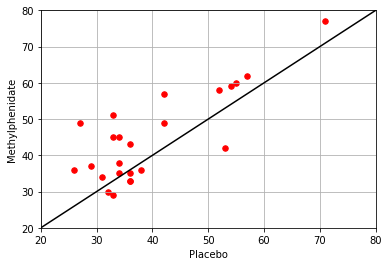

In [31]:
data.plot.scatter('Placebo', 'Methylphenidate', c = 'r', s = 30)
plt.grid()
plt.plot(range(100), c = 'black')
plt.xlim((20, 80))
plt.ylim((20, 80))
plt.show()

## Одновыборочный критерий Стьюдента

Исходя из того, что способность к подавлению испульсивных поведенческих реакций измеряется по шкале [0, 100], можно предположить, что при хорошей калибровке теста средняя способоность к подавлению реакций в популяции составляет 50. Тогда для того, чтобы проверить гипотезу о том, что пациенты в выборке действительно в среднем хуже справляются с подавлением импульсивных реакций (нуждаются в лечении), давайте проверим, что их способность к подавлению реакций отличается от средней (не равна 50). 

$H_0\colon$ среднее значение способности к подавлению испульсивных поведенческих реакций равно 50.

$H_1\colon$ не равно.

In [40]:
# проверьте гипотезу H_0 с помощью stats.ttest_1samp

In [35]:
print("95%% confidence interval: [%f, %f]" % zconfint(data.Placebo))

95% confidence interval: [35.223273, 44.276727]


## Двухвыборочный критерий Стьюдента (независимые выборки)

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.

In [46]:
np.random.normal(1000)

998.1647992294752

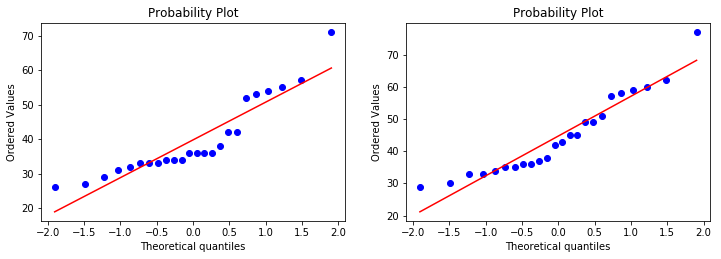

In [42]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(data.Placebo, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(data.Methylphenidate, dist="norm", plot=plt)
plt.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ способности к подавлению импульсивных реакций распредлены нормально
 
 $H_1\colon$ не нормально.

In [49]:
print("Placebo, Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Placebo))

Placebo, Shapiro-Wilk normality test, W-statistic: 0.857487, p-value: 0.003020


In [50]:
print("Methylphenidate, Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data.Methylphenidate))

Methylphenidate, Shapiro-Wilk normality test, W-statistic: 0.916445, p-value: 0.048768


С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_0\colon$ не одинаковы.

In [52]:
#используйте scipy.stats.ttest_ind с equal_var = False

## Двухвыборочный критерий Стьюдента (зависмые выборки)

Для того, чтобы использовать критерй Стьюдента для связанных выборок, давайте проверим, что распределение попарных разностей существенно не отличается от нормального.

In [53]:
# проверьте это

Критерий Стьюдента:

$H_0\colon$ средние значения способности к подавлению испульсивных поведенческих реакций одинаковы для пациентов, принимавших препарат, и для пациентов, принимавших плацебо.

$H_1\colon$ не одинаковы.

In [58]:
# если всё ок, примените stats.ttest_rel. Отвергаем или принимаем H0?

In [54]:
print("95%% confidence interval: [%f, %f]" % DescrStatsW(data.Methylphenidate - data.Placebo).tconfint_mean())

95% confidence interval: [1.775236, 8.141431]


# Непараметрические критерии

### Для одной выборки
  
  
  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Mirrors as potential environmental enrichment for individually housed laboratory mice

(Sherwin, 2004): 16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

In [59]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [63]:
mouses_data = pd.read_csv('mirror_mice.txt', header = None)
mouses_data.columns = ['proportion_of_time']

In [64]:
mouses_data

,proportion_of_time
0,0.348471
1,0.640620
2,0.549818
3,0.537454
4,0.400444
5,0.426292
6,0.417156
7,0.477977
8,0.450657
9,0.476602


In [65]:
mouses_data.describe()

,proportion_of_time
count,16.000000
mean,0.475289
std,0.066065
min,0.348471
25%,0.444566
50%,0.477289
75%,0.488859
max,0.640620


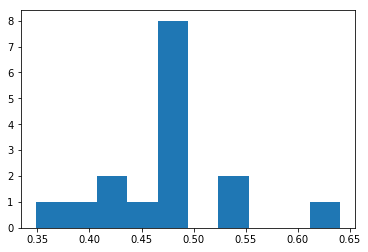

In [66]:
plt.hist(mouses_data.proportion_of_time)
plt.show()

## Одновыборочные критерии

### Критерий знаков

$H_0\colon$ медиана доли времени, проведенного в клетке с зеркалом, равна 0.5

$H_1\colon$ медиана доли времени, проведенного в клетке с зеркалом, не равна 0.5

In [113]:
# примените sign_test и выведите p-value

### Критерий знаковых рангов Вилкоксона

In [69]:
# примените stats.wilcoxon